This notebook helps manually curate SWRs identified using NeuroPy modules.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

# Comment here to add in for either mac or linux computer
# sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # For mac laptop
sys.path.extend(['/data/GitHub/NeuroPy'])  # for linux

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO

In [70]:
# Helper functions to block printing output
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


In [2]:
basepath = '/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_18_habituation'
swr_epochs_file = 'Finn_habituation2_denoised.ripple.npy'

In [3]:
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        eeg_files = sorted(basepath.glob("*.eeg"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        assert len(eeg_files) == 1, "Found more than one .eeg file"

        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        self.eegfile = BinarysignalIO(eeg_files[0],
                                      n_channels=self.recinfo.n_channels,
                                      sampling_rate=self.recinfo.eeg_sampling_rate,
                                      )

sess = ProcessData(basepath)

In [4]:
print(sess.recinfo)
print(sess.eegfile)

filename: /data/Working/Trace_FC/Recording_Rats/Finn/2022_01_18_habituation/Finn_habituation2_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3158.17 seconds 
duration: 0.88 hours 



In [5]:
swr_epochs = core.Epoch(None, file=(sess.basepath / swr_epochs_file))

In [ ]:
# NRK reload previously curated file to check/update
save_file = sess.filePrefix.with_suffix('.ripple_curated.npy')
swr_epochs = core.Epoch(None, file=save_file)

Here is the magic code - should auto-save (CHECK EARLY to make sure it is working!). Still a bit buggy on the save side but looks good in general!  
  
Can navigate with L/R keys if mouse is over "good_ripple" box or slider. Can wrap around ONLY if over "good_ripple" box

Text(value='Enter start/stop with space in between.', description='SWR to add:', layout=Layout(width='80%'))

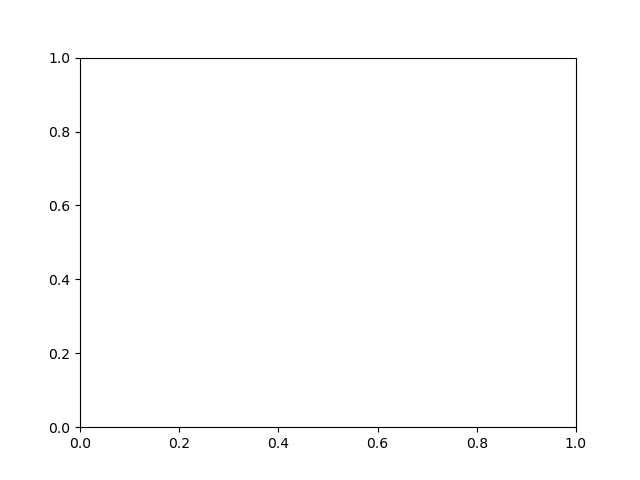

In [75]:
%matplotlib widget
from ipywidgets import interact, fixed
import ipywidgets as widgets
from ipyevents import Event

"""Enter in values here"""
cand_epochs = swr_epochs
chan_plot=np.arange(19, 32)
buffer_sec=0.25

"""Don't change"""
if "good_ripple" in cand_epochs._epochs.keys():
    epochs_use = cand_epochs._epochs[["start", "stop", "label", "good_ripple"]].copy()
    start_id = np.where(cand_epochs._epochs["good_ripple"])[0][-1]
else:
    epochs_use = cand_epochs._epochs[["start", "stop", "label"]].copy()
    epochs_use["good_ripple"] = np.zeros(nevents, dtype=bool)
    start_id = 0
nevents = epochs_use.shape[0]
fig, ax = plt.subplots()

"""Setup variables and widgets"""
lfp = sess.eegfile.get_signal().traces
sid = widgets.IntSlider(min=0, max=(nevents - 1), step=1, 
                        value=start_id)
SR = sess.eegfile.sampling_rate
buffer_frames = int(SR*buffer_sec)
good_ripple=widgets.Checkbox(
   value=epochs_use["good_ripple"][start_id],
    description='Good ripple?',
    disabled=False,
    indent=False
)
good_ripple.layout.border = '2px solid red'
d = Event(source=good_ripple, watched_events=['keydown'])

std = np.std(lfp[chan_plot])

def plot_lfp2(sender):
    """Set up stuff"""
    start_stop = epochs_use[["start", "stop"]].values[sid.value]
    global chan_plot
    if chan_plot is None:
        chan_plot = np.arange(lfp.shape[0])
    nchan = len(chan_plot)
    frame_start = int(start_stop[0] * SR - buffer_frames)
    frame_stop = int(start_stop[1] * SR + buffer_frames)
    lfp_snippet = lfp[chan_plot, frame_start:frame_stop]
    
    time = np.arange(frame_start, frame_stop, 1)/SR
    
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    
    """Plot"""
    offset = 0
    for idt, trace in enumerate(lfp_snippet):
        data = trace - offset
        if idt == 0:
            ymax = data.max() + std
        elif idt == nchan - 1:
            ymin = data.min() - std
        ax.plot(time, data, 'b')
        offset += std*0.5
    
    ax.axvspan(start_stop[0], start_stop[1], color=[0, 1, 0, 0.4])
    
    ax.set_xlim([time.min(), time.max()])
    ax.set_ylim([ymin, ymax])

    """Update checkbox"""
    good_ripple.value = bool(epochs_use.loc[sid.value, "good_ripple"])
    
def save_epochs(sender):
    blockPrint()
    save_file = sess.filePrefix.with_suffix('.ripple_curated.npy')
    cand_epochs._epochs = epochs_use
    cand_epochs.save(save_file)
    enablePrint()

def update_array(sender):
    epochs_use.loc[sid.value, "good_ripple"] = good_ripple.value
    save_epochs(sender)
    
def handle_keypress(event):
    if event["key"] == "ArrowRight":
        print('test')
        sid.value = sid.value + 1 if sid.value < sid.max else sid.min
    elif event["key"] == "ArrowLeft":
        sid.value = sid.value -1 if sid.value > sid.min else sid.max
    
add_epoch_box = widgets.Text(description='SWR to add:', value='Enter start/stop with space in between.',
                            layout=widgets.Layout(width='80%'))
def update_epochs(sender):
    try:
        added_epoch = [float(val) for val in add_epoch_box.value.split(' ')]
        added_epoch.extend(["manual", "False"])
        epochs_use.loc[-1] = added_epoch
        epochs_use.sort_values("start", ignore_index=True, inplace=True)
        sid.max=epochs_use.shape[0] - 1
        add_epoch_box.value = 'Successfully Added'
    except:
        add_epoch_box.value = "Data entered improperly. Enter start/stop with space in between." 

add_epoch_box.on_submit(update_epochs)
display(add_epoch_box)        

good_ripple.observe(update_array)
sid.observe(plot_lfp2)
d.on_dom_event(handle_keypress)
save_button = widgets.Button(
    description='Click me to Save (Not working)',
    disabled=False,
    button_style='', 
    tooltip='Click me',
    icon='check'
)

save_button.observe(save_epochs)
widgets.VBox([sid, good_ripple, save_button])

In [67]:
save_epochs()

/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_18_habituation/Finn_habituation2_denoised.ripple_curated.npy saved
Saved!


In [66]:
save_file = sess.filePrefix.with_suffix('.ripple_curated.npy')
cand_epochs._epochs = epochs_use
# np.save(save_file, cand_epochs._epochs)
cand_epochs.save(save_file)

/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_18_habituation/Finn_habituation2_denoised.ripple_curated.npy saved


In [43]:
epochs_test = np.load(save_file, allow_pickle=True).item()['epochs']

In [44]:
epochs_test

,start,stop,label,good_ripple
0,27.7544,28.0648,,False
1,41.0500,41.1500,manual,True
2,41.1864,41.2896,,True
3,56.9104,57.0376,,True
4,74.5784,74.7424,,False
...,...,...,...,...
431,3108.1984,3108.3120,,False
432,3109.1200,3109.2336,,False
433,3109.6280,3109.7728,,False
434,3110.1976,3110.3712,,False


In [34]:
epochs_test

array([[27.7544, 28.0648, '', False],
       [41.05, 41.15, 'manual', True],
       [41.1864, 41.2896, '', True],
       ...,
       [3109.628, 3109.7728, '', False],
       [3110.1976, 3110.3712, '', False],
       [3119.1664, 3119.276, '', False]], dtype=object)

# To add
1)Ability to reload from saved file + keep track of current index somewhere.
2) Update max value on slider! Can't access last ripples!


## NRK - add last saved time next to box.

Once the above works, add in function to combine sharp-wave and ripple epochs for curating!

~~Finally, make it easy to scoll with the keypad, NOT just the slider.  Basically, write another key callback function that updates the slider value whenever the right or left keys are pushed.~~

Figure out a way to not accidentally overwrite things! Make a "save" button that pre-populates an original name like "swr_curated_001". Also auto-save things every so often just in case with current position!!!

~~Better yet, write mouse callback function to add in swr epochs by drawing on plot in case you see a missed SWR!!!~~